In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import pickle

from sklearn.preprocessing import StandardScaler

In [23]:
import csv
from binance.client import Client

API_KEY = 'M383JsArM1hONvFI5B5yenGWAv3fe2N97J1Lxa7ylqPE2fZERCOhy3K4uJwMsFT5'
API_SECRET = 'Yvde8q4bBfLT9bZQrRRpwt8Gb9Uj3EfETjIpnuCVW7uU705HXNUQxFgpIrO6XXbe'

client = Client(API_KEY, API_SECRET)


btc_candlesticks = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_4HOUR, "1 Dec, 2020", "15 Jul, 2021")
eth_candlesticks = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_4HOUR, "1 Dec, 2020", "15 Jul, 2021")
ada_candlesticks = client.get_historical_klines("ADAUSDT", Client.KLINE_INTERVAL_4HOUR, "1 Dec, 2020", "15 Jul, 2021")

In [60]:
btc=[]
eth=[]
ada=[]
bnb=[]

for i in range(len(btc_candlesticks)):
    btc.append(np.array(btc_candlesticks[i][4]))
    eth.append(np.array(eth_candlesticks[i][4]))
    ada.append(np.array(ada_candlesticks[i][4]))
    
btc=[float(i) for i in btc]
eth=[float(i) for i in eth]
ada=[float(i) for i in ada]

d = {'BTC': btc, 'ETH': eth, "ADA":ada}
data = pd.DataFrame(data=d)

In [65]:
data

,BTC,ETH,ADA
0,19419.74,605.14,0.16829
1,19515.63,610.80,0.16920
2,19425.00,615.93,0.16716
3,19263.37,603.94,0.16106
4,19069.79,599.50,0.15758
...,...,...,...
1352,32451.99,1949.00,1.25060
1353,32786.00,1995.82,1.27230
1354,32729.76,1980.22,1.26360
1355,32820.02,1994.58,1.26350


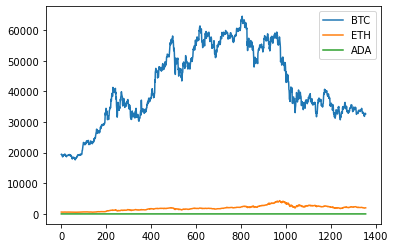

In [66]:
data.plot()

In [67]:
class MultiStockEnv:

    
    def __init__(self, data, initial_investment=20000):
        # data
        self.stock_price_history = data
        self.n_step, self.n_stock = self.stock_price_history.shape

        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None

        self.action_space = np.arange(3**self.n_stock)

        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

        self.state_dim = self.n_stock * 2 + 1

        self.reset()


    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()


    def step(self, action):
        assert action in self.action_space

        prev_val = self._get_val()

        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]

        self._trade(action)

        cur_val = self._get_val()

        reward = cur_val - prev_val

        done = self.cur_step == self.n_step - 1

        info = {'cur_val': cur_val}

        return self._get_obs(), reward, done, info


    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock:2*self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs
    
    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand

    def _trade(self, action):

        action_vec = self.action_list[action]

        sell_index = [] 
        buy_index = [] 
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            elif a == 2:
                buy_index.append(i)


        if sell_index:
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0
        if buy_index:

            can_buy = True
            while can_buy:
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1 
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        can_buy = False

In [68]:
n_timesteps, n_stocks = data.shape

In [69]:
n_train = n_timesteps // 2
n_train

678

In [70]:
train_data = data[:n_train].values
test_data = data[n_train:].values

In [71]:
env = MultiStockEnv(train_data,initial_investment=20000)

In [75]:
env.reset()

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 1.941974e+04,
       6.051400e+02, 1.682900e-01, 2.000000e+04])

In [76]:
env.action_list

[[0, 0, 0],
 [0, 0, 1],
 [0, 0, 2],
 [0, 1, 0],
 [0, 1, 1],
 [0, 1, 2],
 [0, 2, 0],
 [0, 2, 1],
 [0, 2, 2],
 [1, 0, 0],
 [1, 0, 1],
 [1, 0, 2],
 [1, 1, 0],
 [1, 1, 1],
 [1, 1, 2],
 [1, 2, 0],
 [1, 2, 1],
 [1, 2, 2],
 [2, 0, 0],
 [2, 0, 1],
 [2, 0, 2],
 [2, 1, 0],
 [2, 1, 1],
 [2, 1, 2],
 [2, 2, 0],
 [2, 2, 1],
 [2, 2, 2]]

In [77]:
env.step(26)

(array([1.000000e+00, 0.000000e+00, 1.000000e+00, 1.951563e+04,
        6.108000e+02, 1.692000e-01, 4.842008e+02]),
 0.0,
 False,
 {'cur_val': 20000.0})

In [78]:
def predict(X,W,b):

    assert(len(X.shape) == 2)
    return X.dot(W) + b

In [79]:
def sgd(X, Y,W,b,vW,vb,learning_rate=0.01, momentum=0.9):
    assert(len(X.shape) == 2)
    num_values = np.prod(Y.shape)
    Yhat = predict(X,W,b)
    gW = 2 * X.T.dot(Yhat - Y) / num_values
    gb = 2 * (Yhat - Y).sum(axis=0) / num_values

    vW = momentum * vW - learning_rate * gW
    vb = momentum * vb - learning_rate * gb

    W += vW
    b += vb
    return W,b,vW,vb

In [81]:
def greedy_policy(state,W,b,epsilon):
    if np.random.rand() <= epsilon:
        return np.random.choice(action_size)
    else:
        act_values = predict(state,W,b)
        return np.argmax(act_values[0])  # returns action

In [82]:
def get_scaler(env):
    states = []
    for i in range(100):
        for j in range(env.n_step):
            action = np.random.choice(env.action_space)
            state, reward, done, info = env.step(action)
            states.append(state)
            if done:
                env.reset()
                break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

In [85]:
gamma = 0.95  
epsilon = 1.0  
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 2000
initial_investment = 20000

n_timesteps, n_stocks = data.shape
n_train = n_timesteps // 2
train_data = data[:n_train].values
test_data = data[n_train:].values
np.random.seed(1)
env = MultiStockEnv(train_data,initial_investment=20000)

state_size = env.state_dim
action_size = len(env.action_space)

W = np.random.randn(state_size, action_size) / np.sqrt(state_size)
b = np.zeros(action_size)

scaler=get_scaler(env)

vW = 0
vb = 0

portfolio_value = []
for i in range(num_episodes):
    done=False
    state = env.reset()
    state = scaler.transform([state])
    while not done:
        action = greedy_policy(state,W,b,epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        if done:
            target = reward
        else:
            target = reward + gamma * np.amax(predict(next_state,W,b), axis=1)
        target_full = predict(state,W,b)
        target_full[0, action] = target
        W,b,vW,vb=sgd(X=state, Y=target_full,W=W,b=b,vW=vW,vb=vb)
        
        state=next_state
        
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
        
    val=info['cur_val']
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {val:.2f}")
    portfolio_value.append(val)
pickle.dump(scaler, open('scaler.pkl','wb'))
np.savez("TraderWeights.npz", W=W, b=b)

episode: 1/2000, episode end value: 86023.27
episode: 2/2000, episode end value: 135675.32
episode: 3/2000, episode end value: 137000.25
episode: 4/2000, episode end value: 155390.70
episode: 5/2000, episode end value: 38352.37
episode: 6/2000, episode end value: 136623.96
episode: 7/2000, episode end value: 179782.50
episode: 8/2000, episode end value: 96026.50
episode: 9/2000, episode end value: 134599.83
episode: 10/2000, episode end value: 130871.13
episode: 11/2000, episode end value: 123245.46
episode: 12/2000, episode end value: 131573.81
episode: 13/2000, episode end value: 167175.86
episode: 14/2000, episode end value: 162150.34
episode: 15/2000, episode end value: 125703.55
episode: 16/2000, episode end value: 178205.64
episode: 17/2000, episode end value: 132444.97
episode: 18/2000, episode end value: 63808.94
episode: 19/2000, episode end value: 129802.84
episode: 20/2000, episode end value: 60148.94
episode: 21/2000, episode end value: 68368.67
episode: 22/2000, episode en

In [86]:
scaler = pickle.load(open('scaler.pkl', 'rb'))
npz = np.load("TraderWeights.npz")
W = npz['W']
b = npz['b']

In [87]:
W

array([[-3.62770664e+02, -3.24687195e+02,  4.32482483e+02,
        -5.90036776e+01, -3.51702663e+02,  9.16078117e+02,
        -1.19655617e+02, -3.28631109e+02, -1.24156253e+02,
         1.94613405e+01, -1.45710270e+02, -3.09310977e+02,
        -1.07208723e+02, -5.37469623e+01, -5.28768197e+02,
        -1.98509193e+02, -1.59425195e+02,  1.35955013e+02,
        -1.99499110e+02,  6.35681754e+01, -3.91226533e+01,
        -6.34189407e+01, -4.46090389e+01,  5.13356012e+01,
        -4.07682081e+01, -1.35991387e+02, -8.76077254e+00],
       [-3.72530200e+02, -2.58238359e+02,  4.31897142e+01,
        -4.46074473e+02, -3.22842151e+02, -7.31837082e+02,
        -5.54228056e+01, -1.05792118e+02,  2.27415378e+01,
        -1.92966263e+02, -1.59622749e+02,  2.60900919e+02,
        -3.05986503e+01, -5.88962559e+02, -4.53864189e+02,
        -2.42148910e+02, -3.46888527e+02, -4.46878022e+01,
         3.73666856e+02, -1.22781496e+02, -6.21589423e+01,
        -1.87063336e+02, -1.59667817e+01, -8.47512249e+

In [88]:
np.random.seed(1)

epsilon = 0.01
env = MultiStockEnv(test_data, initial_investment)
testportfoliovalues=[]
for i in range(num_episodes):
    state = env.reset()
    state = scaler.transform([state])
    done=False
    while not done:
        action = greedy_policy(state,W,b,epsilon=epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
    value=info['cur_val']
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {value:.2f}")
    testportfoliovalues.append(value) 

episode: 1/2000, episode end value: 19555.04
episode: 2/2000, episode end value: 19787.52
episode: 3/2000, episode end value: 19372.48
episode: 4/2000, episode end value: 19672.13
episode: 5/2000, episode end value: 19238.00
episode: 6/2000, episode end value: 19864.87
episode: 7/2000, episode end value: 20568.90
episode: 8/2000, episode end value: 18926.68
episode: 9/2000, episode end value: 19559.23
episode: 10/2000, episode end value: 20907.04
episode: 11/2000, episode end value: 17801.40
episode: 12/2000, episode end value: 19656.29
episode: 13/2000, episode end value: 19448.78
episode: 14/2000, episode end value: 18536.25
episode: 15/2000, episode end value: 19517.93
episode: 16/2000, episode end value: 20620.46
episode: 17/2000, episode end value: 19779.07
episode: 18/2000, episode end value: 18462.88
episode: 19/2000, episode end value: 19262.79
episode: 20/2000, episode end value: 18438.40
episode: 21/2000, episode end value: 18948.18
episode: 22/2000, episode end value: 19020.

In [89]:
np.random.seed(1)

epsilon = 1
env = MultiStockEnv(test_data, initial_investment)
randomportfoliovalues=[]
for i in range(num_episodes):
    state = env.reset()
    state = scaler.transform([state])
    done=False
    while not done:
        action = greedy_policy(state,W,b,epsilon=epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
    value=info['cur_val']
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {value:.2f}")
    randomportfoliovalues.append(value) 

episode: 1/2000, episode end value: 18252.42
episode: 2/2000, episode end value: 34402.06
episode: 3/2000, episode end value: 19982.44
episode: 4/2000, episode end value: 13597.69
episode: 5/2000, episode end value: 24183.42
episode: 6/2000, episode end value: 19082.48
episode: 7/2000, episode end value: 23786.46
episode: 8/2000, episode end value: 20026.91
episode: 9/2000, episode end value: 40953.12
episode: 10/2000, episode end value: 18649.18
episode: 11/2000, episode end value: 35180.51
episode: 12/2000, episode end value: 12156.08
episode: 13/2000, episode end value: 21665.38
episode: 14/2000, episode end value: 48024.70
episode: 15/2000, episode end value: 38002.61
episode: 16/2000, episode end value: 13578.97
episode: 17/2000, episode end value: 16582.35
episode: 18/2000, episode end value: 31807.56
episode: 19/2000, episode end value: 32891.74
episode: 20/2000, episode end value: 27628.65
episode: 21/2000, episode end value: 29821.68
episode: 22/2000, episode end value: 11771.

In [90]:
np.savez("TraderPortfolios.npz", TrainingPortfolio=portfolio_value, 
         TestPortfolio=testportfoliovalues,
         RandomPortfolio=randomportfoliovalues)

In [91]:
npz = np.load("TraderPortfolios.npz")
TrainingPortfolio=npz['TrainingPortfolio']
RandomPortfolio=npz['RandomPortfolio']
TestPortfolio=npz['TestPortfolio']

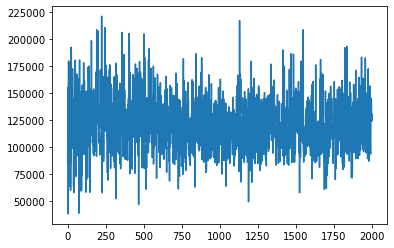

In [92]:
plt.plot(TrainingPortfolio)

(array([  5.,  34., 173., 469., 615., 463., 161.,  57.,  13.,  10.]),
 array([ 38352.37046999,  56628.63600221,  74904.90153444,  93181.16706666,
        111457.43259888, 129733.6981311 , 148009.96366332, 166286.22919555,
        184562.49472777, 202838.76025999, 221115.02579221]),
 <a list of 10 Patch objects>)

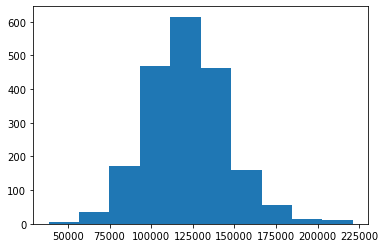

In [93]:
plt.hist(TrainingPortfolio)

In [94]:
np.mean(TestPortfolio)

19118.775050465956

(array([   8.,   49.,   49.,   61.,  183., 1067.,  492.,   71.,   16.,
           4.]),
 array([11677.0717    , 13017.14303   , 14357.21436   , 15697.28569   ,
        17037.35702   , 18377.42835   , 19717.49968   , 21057.57101001,
        22397.64234001, 23737.71367001, 25077.78500001]),
 <a list of 10 Patch objects>)

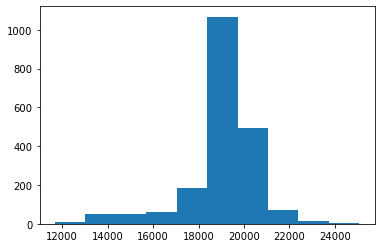

In [95]:
plt.hist(TestPortfolio)

(array([155., 530., 594., 328., 227., 104.,  32.,  19.,   6.,   5.]),
 array([ 6899.91864003, 12577.34982401, 18254.781008  , 23932.21219198,
        29609.64337597, 35287.07455995, 40964.50574394, 46641.93692792,
        52319.36811191, 57996.79929589, 63674.23047988]),
 <a list of 10 Patch objects>)

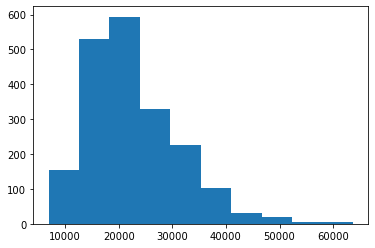

In [96]:
plt.hist(RandomPortfolio)

In [97]:
np.mean(RandomPortfolio)

22659.92708140178

In [98]:
test_data[-1]

array([3.264165e+04, 1.979280e+03, 1.243800e+00])

In [99]:
PercentIncrease=(test_data[-1]-test_data[0])/test_data[0]

In [100]:
np.mean(PercentIncrease)

-0.03264959907393072